In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from scipy.stats import ttest_1samp
import random

Collect data for Eurojackpot spanning 12 years through web scraping.

In [199]:
# give year information as a list

year_list = [2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]
date_list = []

# Retrieve all dates for each year using the URL and append them to a list
for year in year_list:    
    url = 'https://www.lottonumbers.com/eurojackpot-results-' + str(year)
    response = requests.get(url)
    soup = BeautifulSoup(response.content)
    date_box = soup.find('table', attrs= {'class':'lotteryTable'}).find('tbody').find_all('a')
    for date in date_box:
        date_list.append(date.get('href').split('/')[3])
# print(date_list)
        
# Retrieve 'Balls' information using URL
jackpot_df = pd.DataFrame()
for date in date_list:
    url = 'https://www.lottonumbers.com/eurojackpot/results/' + date
    response = requests.get(url)
    soup = BeautifulSoup(response.content)
    balls = [li.text.strip().split()[0] for li in soup.find('ul', attrs={'class':"balls -lg -cn"}).find_all('li')]
    # print(balls)

    #Retrieve 'Prize Tier', 'Per Winner Prize', 'Total Winners' information using table in soup, and append into df
    prize_breakdown = soup.find('table', attrs= {'class':"table-breakdown"})
    draw_df =  pd.read_html(str(prize_breakdown))[0]
    #Append 'Balls' and 'Date' information into df
    draw_df['Balls'] = str(','.join(balls))
    draw_df['Date'] = date
    # print(draw_df.head())

    ###DATA CLEANING
    #remove rows where ['Prize Tier'] = 'Totals'
    draw_df = draw_df[draw_df['Prize Tier'] != 'Totals']

    #clean Prize Tier column
    draw_df['Prize Tier'] = draw_df['Prize Tier'].apply(lambda x: '+'.join([n if n.isdigit() else '0' for n in x.split()[1:] if n.isdigit()]) if 'and' in x else f'{x.split()[1]}+0')
    
    #concat two dataframes in jackpot_df
    jackpot_df = pd.concat([jackpot_df, draw_df], ignore_index=True)
jackpot_df.head()

,Prize Tier,Per Winner Prize,Total Winners,Balls,Date
0,5+2,"€21,000,000.00",Rollover 0,"5,8,22,32,39,7,8",2012-12-28
1,5+1,"€246,863.80",3,"5,8,22,32,39,7,8",2012-12-28
2,5+0,"€24,205.20",4,"5,8,22,32,39,7,8",2012-12-28
3,4+2,"€6,874.80",13,"5,8,22,32,39,7,8",2012-12-28
4,4+1,€190.10,372,"5,8,22,32,39,7,8",2012-12-28


In [203]:
# Export the data to both a CSV and an Excel file
jackpot_df.to_csv('Data/Eurojackpot_raw.csv')
jackpot_df.to_excel('Data/Eurojackpot_raw.xlsx')

Data Cleaning

In [2]:
jackpot_df = pd.read_excel('Data/Eurojackpot_raw.xlsx')

In [3]:
jackpot_df.loc[jackpot_df['Total Winners'] == 'Rollover  0', 'Total Winners'] = 0
jackpot_df['Total Winners'] = pd.to_numeric(jackpot_df['Total Winners'], errors='coerce').astype('Int64')

In [4]:
jackpot_df.dtypes

Unnamed: 0           int64
Prize Tier          object
Per Winner Prize    object
Total Winners        Int64
Balls               object
Date                object
dtype: object

In [5]:
# change data types
jackpot_df['Per Winner Prize'] = jackpot_df['Per Winner Prize'].str.replace('[^0-9.]', '', regex=True).astype(float)
jackpot_df['Date'] = jackpot_df['Date'].astype('datetime64[ns]')
# jackpot_df['Total Winners'] = jackpot_df['Total Winners'].str.replace('[^0-9.]', '', regex=True).fillna(0).astype('int')
jackpot_df.dtypes

Unnamed: 0                   int64
Prize Tier                  object
Per Winner Prize           float64
Total Winners                Int64
Balls                       object
Date                datetime64[ns]
dtype: object

In [6]:
jackpot_df.head(10)

,Unnamed: 0,Prize Tier,Per Winner Prize,Total Winners,Balls,Date
0,0,5+2,21000000.0,0,"5,8,22,32,39,7,8",2012-12-28
1,1,5+1,246863.8,3,"5,8,22,32,39,7,8",2012-12-28
2,2,5+0,24205.2,4,"5,8,22,32,39,7,8",2012-12-28
3,3,4+2,6874.8,13,"5,8,22,32,39,7,8",2012-12-28
4,4,4+1,190.1,372,"5,8,22,32,39,7,8",2012-12-28
5,5,4+0,96.9,461,"5,8,22,32,39,7,8",2012-12-28
6,6,3+2,69.7,908,"5,8,22,32,39,7,8",2012-12-28
7,7,3+1,18.1,16805,"5,8,22,32,39,7,8",2012-12-28
8,8,2+2,17.9,14332,"5,8,22,32,39,7,8",2012-12-28
9,9,3+0,14.0,19093,"5,8,22,32,39,7,8",2012-12-28


In [7]:
jackpot_df.to_excel('Data/Eurojackpot.xlsx')
jackpot_df = jackpot_df.sort_values(by='Date')

In [8]:
# calculate total_reward and total_deposit and append into a df
total_reward = jackpot_df[jackpot_df['Prize Tier'] == '2+1']
total_reward['Total Reward'] = total_reward.apply(lambda row: (row['Per Winner Prize']) * (row['Total Winners']) * (100/20.3), axis=1)
total_reward['Total Deposit'] = total_reward['Total Reward'] * 2

total_reward = total_reward.drop(columns='Unnamed: 0')
total_reward.tail()
# total_reward.dtypes


/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_23708/589820868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_reward['Total Reward'] = total_reward.apply(lambda row: (row['Per Winner Prize']) * (row['Total Winners']) * (100/20.3), axis=1)
/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_23708/589820868.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_reward['Total Deposit'] = total_reward['Total Reward'] * 2


,Prize Tier,Per Winner Prize,Total Winners,Balls,Date,Total Reward,Total Deposit
7247,2+1,10.6,711460,"2,21,34,40,48,2,6",2023-12-29,3.715013e+07,7.430026e+07
8531,2+1,11.1,527283,"19,26,36,48,49,10,11",2024-01-02,2.883173e+07,5.766346e+07
8519,2+1,10.6,894780,"11,30,32,45,47,3,10",2024-01-05,4.672250e+07,9.344500e+07
8507,2+1,9.9,743261,"9,12,26,41,47,7,10",2024-01-09,3.624770e+07,7.249541e+07
8495,2+1,10.3,957645,"3,31,34,43,45,6,9",2024-01-12,4.858987e+07,9.717974e+07


In [9]:
# Find all big_reward data and export it to an Excel file
big_reward = jackpot_df[jackpot_df['Prize Tier'] == '5+2'][['Date', 'Per Winner Prize']]
big_reward = big_reward.rename(columns={'Per Winner Prize': 'Jackpot Prize'})

big_reward.head()


,Date,Jackpot Prize
480,2012-03-23,10000000.0
468,2012-03-30,11000000.0
456,2012-04-06,12000000.0
444,2012-04-13,14000000.0
432,2012-04-20,15000000.0


In [10]:
# Export the data to an Excel file
total_reward = total_reward.merge(big_reward, on='Date', how='inner')
total_reward.head()
total_reward.to_excel('Data/total_reward.xlsx')

In [11]:
# Calculate potential profit by giving winning probabilities for each tier and append it to jackpot_df
winning_probabilities = {
    '5+2': 1/139838160,
    '5+1': 1/6991908,
    '5+0': 1/3107515,
    '4+2': 1/621503,
    '4+1': 1/31075,
    '4+0': 1/13811,
    '3+2': 1/14125,
    '3+1': 1/706,
    '3+0': 1/314,
    '2+2': 1/985,
    '2+1': 1/49,
    '1+2': 1/188
}

jackpot_df['potential_profit'] = jackpot_df.apply(lambda row: row['Per Winner Prize'] * winning_probabilities[row['Prize Tier']], axis=1)

jackpot_df.tail(10)

,Unnamed: 0,Prize Tier,Per Winner Prize,Total Winners,Balls,Date,potential_profit
8486,8486,5+0,295917.5,8,"3,31,34,43,45,6,9",2024-01-12,0.095226
8487,8487,4+2,4881.1,80,"3,31,34,43,45,6,9",2024-01-12,0.007854
8492,8492,3+1,21.6,64176,"3,31,34,43,45,6,9",2024-01-12,0.030595
8489,8489,3+2,157.2,3415,"3,31,34,43,45,6,9",2024-01-12,0.011129
8490,8490,4+0,129.7,3009,"3,31,34,43,45,6,9",2024-01-12,0.009391
8491,8491,2+2,23.0,53914,"3,31,34,43,45,6,9",2024-01-12,0.023350
8494,8494,1+2,11.1,296037,"3,31,34,43,45,6,9",2024-01-12,0.059043
8493,8493,3+0,18.9,138941,"3,31,34,43,45,6,9",2024-01-12,0.060191
8488,8488,4+1,355.7,1372,"3,31,34,43,45,6,9",2024-01-12,0.011447
8495,8495,2+1,10.3,957645,"3,31,34,43,45,6,9",2024-01-12,0.210204


In [12]:
# Calculate total potential profit by date and append in a new dataframe
total_potential_profit_by_date = jackpot_df.groupby('Date')['potential_profit'].sum().reset_index()

# Create a new DataFrame with 'Date' and 'Total Potential Profit' columns
profit_df = pd.DataFrame({
    'Date': total_potential_profit_by_date['Date'],
    'Total Potential Profit': total_potential_profit_by_date['potential_profit']
})

profit_df.to_excel('Data/profit.xlsx')
profit_df.tail()

,Date,Total Potential Profit
706,2023-12-29,1.592744
707,2024-01-02,1.501792
708,2024-01-05,1.681000
709,2024-01-09,2.045604
710,2024-01-12,2.094274


In [13]:
total_reward = total_reward.merge(profit_df, on='Date', how='inner')
total_reward.head()
total_reward.to_excel('Data/total_reward.xlsx')

In [14]:
participant = total_reward[['Total Reward','Date']].reset_index()

prediction = pd.DataFrame({
    'Date': profit_df["Date"].tail(16), 
    'Participant': participant['Total Reward'].tail(16),
    'Total Potential Profit': profit_df['Total Potential Profit'].tail(16)
    })
prediction

,Date,Participant,Total Potential Profit
695,2023-11-21,1.071585e+07,0.682314
696,2023-11-24,1.786155e+07,0.566379
697,2023-11-28,1.156279e+07,0.535860
698,2023-12-01,1.963277e+07,0.983873
699,2023-12-05,1.300133e+07,0.697249
700,2023-12-08,2.118637e+07,0.813474
701,2023-12-12,1.461931e+07,1.023369
702,2023-12-15,2.346126e+07,1.039161
703,2023-12-19,1.702924e+07,0.994641
704,2023-12-22,2.877631e+07,1.356668


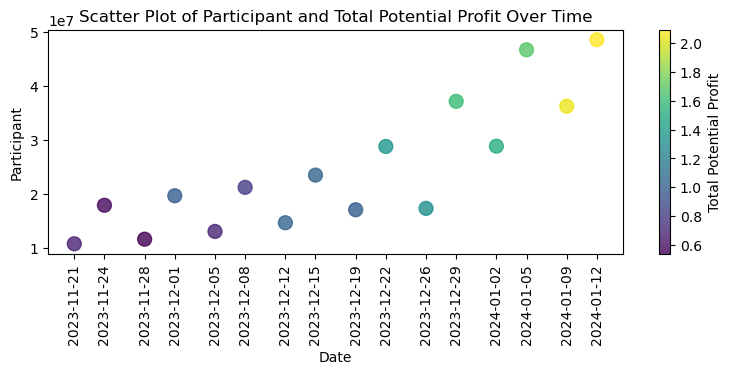

In [15]:
plt.figure(figsize=(8, 4))
plt.scatter(prediction['Date'], prediction['Participant'], c=prediction['Total Potential Profit'], cmap='viridis', s=100, alpha=0.8)
plt.title('Scatter Plot of Participant and Total Potential Profit Over Time')
plt.xlabel('Date')
plt.ylabel('Participant')
plt.colorbar(label='Total Potential Profit')
plt.xticks(prediction['Date'],rotation=90)
plt.tight_layout()

In [16]:
# Convert 'Date' to numeric (days since the start date)
prediction['Date_numeric'] = (prediction['Date'] - prediction['Date'].min()).dt.days
correlation_matrix = prediction[['Date_numeric','Participant', 'Total Potential Profit']].corr()
correlation_matrix

,Date_numeric,Participant,Total Potential Profit
Date_numeric,1.000000,0.841914,0.950635
Participant,0.841914,1.000000,0.890859
Total Potential Profit,0.950635,0.890859,1.000000


Mean Squared Error: 0.036818364942071614


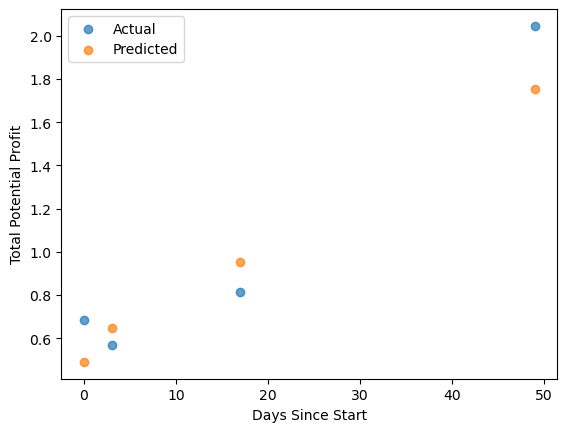

0.9458963280013966

In [17]:

# Split data into features and target
X = prediction[['Date_numeric','Participant']]
y = prediction['Total Potential Profit']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression model
model = LinearRegression()
result = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plotting predictions vs actual values
plt.scatter(X_test['Date_numeric'], y_test, label='Actual', alpha=0.7)
plt.scatter(X_test['Date_numeric'], y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Days Since Start')
plt.ylabel('Total Potential Profit')
plt.legend()
plt.show()

result.score(X_train, y_train)


In [18]:
# Set the target profit to 3
target_profit = 3.0

# Create a DataFrame with a range of 'Date_numeric' values
days_range = pd.DataFrame({'Date_numeric': range(5000), 'Participant': range(50000000, 75000000, 5000)})

# Predict 'Total Potential Profit' for the entire range of dates
predicted_profits = model.predict(days_range[['Date_numeric','Participant']])

# Set the target profit to 3
target_profit = 3

# Find the first date where the predicted profit is greater than or equal to 3
estimated_date_index = np.argmax(predicted_profits >= target_profit)

# Get the estimated date
estimated_date = prediction['Date'].min() + pd.to_timedelta(estimated_date_index, unit='D')

print(f"Estimated date to reach a profit of {target_profit}: {estimated_date} ({estimated_date_index} days later)")


Estimated date to reach a profit of 3: 2024-03-06 00:00:00 (106 days later)


In [19]:
# calculate potential profit by excluding 5+2
# Exclude '5+2' prize tier
filtered_df = jackpot_df[jackpot_df['Prize Tier'] != '5+2']

# Group by 'Date' and sum the potential profit
total_potential_profit_by_date = filtered_df.groupby('Date')['potential_profit'].sum().reset_index()

# Create a new DataFrame with 'Date' and 'Total Potential Profit' columns
profit_wo_bigreward_df = pd.DataFrame({
    'Date': total_potential_profit_by_date['Date'],
    'Total Potential Profit': total_potential_profit_by_date['potential_profit']
})

print(profit_wo_bigreward_df)

          Date  Total Potential Profit
0   2012-03-23                0.384402
1   2012-03-30                0.272262
2   2012-04-06                0.417329
3   2012-04-13                0.275620
4   2012-04-20                0.519859
..         ...                     ...
706 2023-12-29                0.849489
707 2024-01-02                0.659191
708 2024-01-05                0.822865
709 2024-01-09                1.187470
710 2024-01-12                1.236140

[711 rows x 2 columns]


In [20]:
prediction_wo_bigreward = pd.DataFrame({
    'Date': profit_wo_bigreward_df["Date"].tail(16), 
    'Participant': participant['Total Reward'].tail(16),
    'Total Potential Profit': profit_wo_bigreward_df['Total Potential Profit'].tail(16)
    })
prediction_wo_bigreward 


,Date,Participant,Total Potential Profit
695,2023-11-21,1.071585e+07,0.610803
696,2023-11-24,1.786155e+07,0.448624
697,2023-11-28,1.156279e+07,0.388152
698,2023-12-01,1.963277e+07,0.785148
699,2023-12-05,1.300133e+07,0.455382
700,2023-12-08,2.118637e+07,0.508154
701,2023-12-12,1.461931e+07,0.666108
702,2023-12-15,2.346126e+07,0.611693
703,2023-12-19,1.702924e+07,0.507887
704,2023-12-22,2.877631e+07,0.784446


Mean Squared Error: 0.039435162079016414


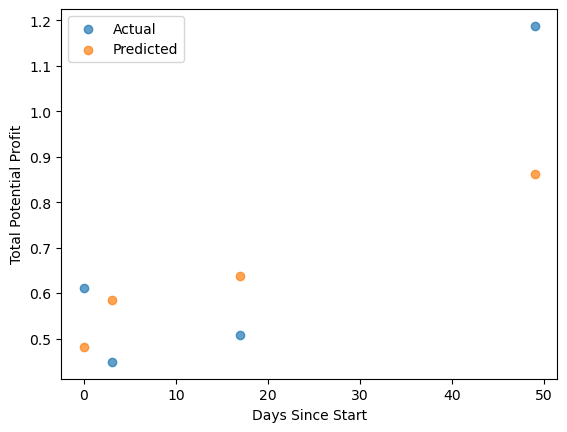

0.7055328051110547

In [21]:
# Convert 'Date' to numeric (days since the start date)
prediction_wo_bigreward['Date_numeric'] = (prediction_wo_bigreward['Date'] - prediction_wo_bigreward['Date'].min()).dt.days

# Split data into features and target
X = prediction_wo_bigreward[['Date_numeric', 'Participant']]
y = prediction_wo_bigreward['Total Potential Profit']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit Linear Regression model
model = LinearRegression()
result = model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Plotting predictions vs actual values
plt.scatter(X_test['Date_numeric'], y_test, label='Actual', alpha=0.7)
plt.scatter(X_test['Date_numeric'], y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Days Since Start')
plt.ylabel('Total Potential Profit')
plt.legend()
plt.show()

result.score(X_train, y_train)

In [22]:
# Set the target profit to 2
target_profit = 2.0

# Create a DataFrame with a range of 'Date_numeric' values
days_range = pd.DataFrame({'Date_numeric': range(5000), 'Participant': range(50000000, 75000000, 5000)})

# Predict 'Total Potential Profit' for the entire range of dates
predicted_profits = model.predict(days_range[['Date_numeric','Participant']])

# Find the first date where the predicted profit is greater than or equal to 3
estimated_date_index = np.argmax(predicted_profits >= target_profit)

# Get the estimated date
estimated_date = prediction['Date'].min() + pd.to_timedelta(estimated_date_index, unit='D')

print(f"Estimated date to reach a profit of {target_profit}: {estimated_date}")

estimated_date_index

Estimated date to reach a profit of 2.0: 2031-10-14 00:00:00


2884

In [23]:
# Calculate company profit and export data to an Excel file
jackpot_df['Total Prize'] = jackpot_df['Per Winner Prize'] * jackpot_df['Total Winners']
total_prize = jackpot_df.groupby('Date')['Total Prize'].sum().reset_index()

# Create a new DataFrame with 'Date' and 'Total Potential Profit' columns
company_profit_df = pd.DataFrame({
    'Date': total_prize['Date'],
    'Total Prize': total_prize['Total Prize']
})


# Merge with total_reward DataFrame on 'Date' to get 'Total Prize' column
company_profit_df = pd.merge(company_profit_df, total_reward[['Date', 'Total Deposit']], on='Date', how='left')
company_profit_df['Company Profit'] = company_profit_df['Total Deposit'] - company_profit_df['Total Prize']


company_profit_df.to_excel('Data/company profit.xlsx')
company_profit_df.tail(30)

,Date,Total Prize,Total Deposit,Company Profit
681,2023-10-03,6798573.5,2.460488e+07,17806302.362069
682,2023-10-06,11427588.0,4.149959e+07,30072006.08867
683,2023-10-10,7730022.4,2.805078e+07,20320752.969458
684,2023-10-13,68051521.6,5.009507e+07,-17956447.708374
685,2023-10-17,6210539.8,2.258748e+07,16376940.988177
686,2023-10-20,10229097.9,3.715604e+07,26926937.56798
687,2023-10-24,6530772.4,2.365200e+07,17121227.6
688,2023-10-27,11063423.9,4.018144e+07,29118014.523645
689,2023-10-31,42776827.9,2.726962e+07,-15507208.195567
690,2023-11-03,9831937.5,3.568136e+07,25849418.165025


Correlation test - Survey and Real data

Lottery Play Tendency Based on Time

In [24]:
date_format = '%Y-%m-%d'
total_reward['Quarter'] = total_reward['Date'].dt.quarter
total_reward.tail(20)

,Prize Tier,Per Winner Prize,Total Winners,Balls,Date,Total Reward,Total Deposit,Jackpot Prize,Total Potential Profit,Quarter
691,2+1,10.0,225042,"26,36,43,47,49,4,7",2023-11-07,1.108581e+07,2.217163e+07,1.417609e+07,0.834947,4
692,2+1,9.3,423960,"1,17,22,29,31,5,6",2023-11-10,1.942280e+07,3.884560e+07,2.159218e+07,0.645016,4
693,2+1,9.8,262226,"9,30,34,38,48,2,3",2023-11-14,1.265919e+07,2.531837e+07,2.793898e+07,0.893146,4
694,2+1,8.8,470497,"4,14,15,20,28,7,9",2023-11-17,2.039593e+07,4.079186e+07,3.652488e+07,0.739745,4
695,2+1,10.1,215378,"9,20,21,22,38,3,12",2023-11-21,1.071585e+07,2.143170e+07,1.000000e+07,0.682314,4
696,2+1,9.1,398450,"16,27,33,34,39,2,7",2023-11-24,1.786155e+07,3.572310e+07,1.646657e+07,0.566379,4
697,2+1,7.8,300929,"11,12,13,23,36,3,8",2023-11-28,1.156279e+07,2.312558e+07,2.065525e+07,0.535860,4
698,2+1,10.6,375986,"23,32,38,45,49,1,9",2023-12-01,1.963277e+07,3.926553e+07,2.778937e+07,0.983873,4
699,2+1,9.5,277818,"6,11,16,26,49,2,9",2023-12-05,1.300133e+07,2.600267e+07,3.382220e+07,0.697249,4
700,2+1,9.1,472619,"2,8,28,32,37,3,6",2023-12-08,2.118637e+07,4.237274e+07,4.269547e+07,0.813474,4


In [25]:
survey_data = pd. DataFrame({'Quarter' : ['Q1', 'Q2', 'Q3', 'Q4'],'Survey Play Count': [16,14,12,36]})

real_play_data = total_reward.groupby('Quarter')['Total Reward'].mean().reset_index().rename(columns = {'Total Reward' : 'Real Play Count'})
real_play_data['Quarter'] = 'Q' + real_play_data['Quarter'].astype(str)


In [26]:
merged_data = pd.merge(survey_data, real_play_data, on='Quarter')

X = merged_data[['Survey Play Count', 'Real Play Count']]

# Normalization/Standardization

transformer = StandardScaler().fit(X)
scaled = pd.DataFrame(transformer.transform(X),columns = X.columns)
scaled
# scaler = MinMaxScaler()
# merged_data[['Survey Play Count', 'Real Play Count']] = scaler.fit_transform(merged_data[['Survey Play Count', 'Real Play Count']])


# Perform correlation test
correlation_coefficient, p_value = pearsonr(scaled['Survey Play Count'], scaled['Real Play Count'])

# Print the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient, p_value}")

if p_value < 0.05:
    if abs(correlation_coefficient) >= 0.5:
        print("There is a statistically significant correlation (|r| >= 0.5) between survey results and real lottery play data.")
    else:
        print("There is a statistically significant correlation, but its magnitude is not strong (|r| < 0.5).")
else:
    print("There is no statistically significant correlation between survey results and real lottery play data.")

Pearson Correlation Coefficient: (0.06423171740632722, 0.9357682825936728)
There is no statistically significant correlation between survey results and real lottery play data.


Lottery Play Tendency Based on Prize

In [27]:
survey_prize_data = pd.DataFrame(
    {'Category': ['Less than 10M', '10-20M','21-30M', '31-40M', '41-50M', 'more than 51M'],
     'Survey Play Count' : [27,9,8,14,12,20]})     
survey_prize_data      

,Category,Survey Play Count
0,Less than 10M,27
1,10-20M,9
2,21-30M,8
3,31-40M,14
4,41-50M,12
5,more than 51M,20


In [28]:
bins = [0, 10000000, 20000000, 30000000,40000000,50000000,float('inf')]  
labels = ['Less than 10M', '10-20M', '21M-30M','31-40M','41-50M', 'more than 51M']  

total_reward['Category'] = pd.cut(total_reward['Jackpot Prize'], bins=bins, labels=labels)


In [29]:
real_prize_data = total_reward.groupby('Category')['Total Reward'].mean().reset_index().rename(columns = {'Total Reward' : 'Real Play Count'})


In [30]:
merged_prize_data = pd.merge(survey_prize_data, real_prize_data, on='Category')

X = merged_prize_data[['Survey Play Count', 'Real Play Count']]

# Normalization/Standardization

transformer = StandardScaler().fit(X)
scaled = pd.DataFrame(transformer.transform(X),columns = X.columns)
scaled
# scaler = MinMaxScaler()
# merged_prize_data[['Survey Play Count', 'Real Play Count']] = scaler.fit_transform(merged_prize_data[['Survey Play Count', 'Real Play Count']])


# Perform correlation test
correlation_coefficient, p_value = pearsonr(scaled['Survey Play Count'], scaled['Real Play Count'])
# Perform correlation test
correlation_coefficient, p_value = pearsonr(merged_prize_data['Survey Play Count'], merged_prize_data['Real Play Count'])

# Print the results
print(f"Pearson Correlation Coefficient: {correlation_coefficient, p_value}")

if p_value < 0.05:
    if abs(correlation_coefficient) >= 0.5:
        print("There is a statistically significant correlation (|r| >= 0.5) between survey results and real lottery play data.")
    else:
        print("There is a statistically significant correlation, but its magnitude is not strong (|r| < 0.5).")
else:
    print("There is no statistically significant correlation between survey results and real lottery play data.")



Pearson Correlation Coefficient: (0.0493397653911047, 0.9372041577339422)
There is no statistically significant correlation between survey results and real lottery play data.


Hypothesis: Those who think playing at a specific time boosts their winning chances are more successful.

In [31]:
survey = pd.read_excel('Data/survey.xlsx')

survey['Category'] = survey['8. Do you believe you are more successful in increasing your chances of winning when playing during a specific time interval?'].map({'Yes': 1, 'Maybe':0, 'No': 0})


In [32]:
#H0: μ >=0.1
#H1: μ <0.1
#95% confidence
ttest_1samp(survey['Category'], 0.1, alternative ='less')
#since p value is lower than 0.05, we can reject null hypothesis. It is evident that
#In the population, individuals who believe that playing at a specific time increases their chances of winning
#are less than 10%

TtestResult(statistic=-2.001303922772438, pvalue=0.025576088810572873, df=47)

## Total Potential Profit Estimation for Current Next Draw

In [33]:
prediction_df = total_reward[["Date", "Total Deposit", "Jackpot Prize", "Total Potential Profit"]]

jackpot_winner_df = jackpot_df[jackpot_df['Prize Tier'] == '5+2'][['Date', 'Per Winner Prize', 'Total Winners']]
jackpot_winner_df.reset_index(drop=True, inplace=True)

jackpot_winner_df.loc[jackpot_winner_df['Per Winner Prize'] == 0, 'Per Winner Prize'] = 10000000.0

jackpot_winner_df["Remainder Jackpot"] = jackpot_winner_df.apply(lambda row: row['Per Winner Prize'] if row['Total Winners'] == 0 else 10000000.0, axis=1)
jackpot_winner_df["Remainder Jackpot"] = jackpot_winner_df["Remainder Jackpot"].shift(1)
jackpot_winner_df.at[0, "Remainder Jackpot"] = 10000000.0  # You can replace 0.0 with any default value if needed
jackpot_winner_df = jackpot_winner_df[["Date", "Remainder Jackpot"]]

prediction_df = prediction_df.merge(jackpot_winner_df, on="Date")

# initial_date = pd.to_datetime('2014-01-01')
# prediction_df = prediction_df[prediction_df['Date'] > initial_date]

prediction_df.tail(20)


,Date,Total Deposit,Jackpot Prize,Total Potential Profit,Remainder Jackpot
691,2023-11-07,2.217163e+07,1.417609e+07,0.834947,1.000000e+07
692,2023-11-10,3.884560e+07,2.159218e+07,0.645016,1.417609e+07
693,2023-11-14,2.531837e+07,2.793898e+07,0.893146,2.159218e+07
694,2023-11-17,4.079186e+07,3.652488e+07,0.739745,2.793898e+07
695,2023-11-21,2.143170e+07,1.000000e+07,0.682314,1.000000e+07
696,2023-11-24,3.572310e+07,1.646657e+07,0.566379,1.000000e+07
697,2023-11-28,2.312558e+07,2.065525e+07,0.535860,1.646657e+07
698,2023-12-01,3.926553e+07,2.778937e+07,0.983873,2.065525e+07
699,2023-12-05,2.600267e+07,3.382220e+07,0.697249,2.778937e+07
700,2023-12-08,4.237274e+07,4.269547e+07,0.813474,3.382220e+07


In [34]:
prediction_df.to_excel('Data/Prediction.xlsx')

In [35]:
url = 'https://www.lottonumbers.com/eurojackpot-results-' + str(2024)
response = requests.get(url)
soup = BeautifulSoup(response.content)
date_box = soup.find('table', attrs= {'class':'lotteryTable'}).find('tbody').find('a')
date = date_box.get('href').split('/')[3]
        
# Retrieve 'Draw' information using URL
url = 'https://www.lottonumbers.com/eurojackpot/results/' + date
response = requests.get(url)
soup = BeautifulSoup(response.content)
balls = [li.text.strip().split()[0] for li in soup.find('ul', attrs={'class':"balls -lg -cn"}).find_all('li')]

#Retrieve 'Prize Tier', 'Per Winner Prize', 'Total Winners' information using table in soup, and append into df
prize_breakdown = soup.find('table', attrs= {'class':"table-breakdown"})
draw_df =  pd.read_html(str(prize_breakdown))[0]
#Append 'Balls' and 'Date' information into df
draw_df['Balls'] = str(','.join(balls))
draw_df['Date'] = date
# print(draw_df.head())

###DATA CLEANING
#remove rows where ['Prize Tier'] = 'Totals'
draw_df = draw_df[draw_df['Prize Tier'] != 'Totals']

#clean Prize Tier column
draw_df['Prize Tier'] = draw_df['Prize Tier'].apply(lambda x: '+'.join([n if n.isdigit() else '0' for n in x.split()[1:] if n.isdigit()]) if 'and' in x else f'{x.split()[1]}+0')

draw_df.loc[draw_df['Total Winners'] == 'Rollover  0', 'Total Winners'] = 0
draw_df['Total Winners'] = pd.to_numeric(draw_df['Total Winners'], errors='coerce').astype('Int64')
draw_df['Per Winner Prize'] = draw_df['Per Winner Prize'].str.replace('[^0-9.]', '', regex=True).astype(float)
draw_df['Date'] = draw_df['Date'].astype('datetime64[ns]')

display(draw_df)

,Prize Tier,Per Winner Prize,Total Winners,Balls,Date
0,5+2,18245011.94,0,"9,18,20,32,39,5,8",2024-01-23
1,5+1,586329.60,2,"9,18,20,32,39,5,8",2024-01-23
2,5+0,66132.50,10,"9,18,20,32,39,5,8",2024-01-23
3,4+2,2948.20,37,"9,18,20,32,39,5,8",2024-01-23
4,4+1,298.30,457,"9,18,20,32,39,5,8",2024-01-23
5,3+2,101.70,1563,"9,18,20,32,39,5,8",2024-01-23
6,4+0,101.70,984,"9,18,20,32,39,5,8",2024-01-23
7,2+2,17.20,22338,"9,18,20,32,39,5,8",2024-01-23
8,3+1,17.20,20359,"9,18,20,32,39,5,8",2024-01-23
9,3+0,17.10,42923,"9,18,20,32,39,5,8",2024-01-23


In [36]:
latest_remainder = draw_df.loc[(draw_df['Total Winners'] == 0) & (draw_df['Prize Tier'] == '5+2'), 'Per Winner Prize'].iloc[-1] if len(draw_df) > 0 else 10000000.0
print(latest_remainder)

18245011.94


In [37]:
winning_probabilities = {
    '5+2': 1/139838160,
    '5+1': 1/6991908,
    '5+0': 1/3107515,
    '4+2': 1/621503,
    '4+1': 1/31075,
    '4+0': 1/13811,
    '3+2': 1/14125,
    '3+1': 1/706,
    '3+0': 1/314,
    '2+2': 1/985,
    '2+1': 1/49,
    '1+2': 1/188
}

draw_df['Total Potential Profit'] = draw_df.apply(lambda row: row['Per Winner Prize'] * winning_probabilities[row['Prize Tier']], axis=1)

total_potential_profit_draw = draw_df.groupby('Date')['Total Potential Profit'].sum().reset_index()
total_potential_profit_draw = total_potential_profit_draw[['Date', 'Total Potential Profit']]

# calculate total_reward and total_deposit and append into a df
total_deposit = draw_df[draw_df['Prize Tier'] == '2+1']
total_deposit['Total Deposit'] = total_deposit.apply(lambda row: (row['Per Winner Prize']) * (row['Total Winners']) * (100/20.3) * 2, axis=1)
total_deposit = total_deposit[['Date', 'Total Deposit']]

big_df = draw_df[draw_df['Prize Tier'] == '5+2'][['Date', 'Per Winner Prize']]
big_df = big_df.rename(columns={'Per Winner Prize': 'Jackpot Prize'})
big_df = big_df[['Date', 'Jackpot Prize']]


last_draw_df = total_potential_profit_draw.merge(total_deposit, on='Date')
last_draw_df = last_draw_df.merge(big_df, on='Date')
last_draw_df.head()

/var/folders/4v/r9p762h55mn0ttvynz3ppd440000gn/T/ipykernel_23708/4158439674.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_deposit['Total Deposit'] = total_deposit.apply(lambda row: (row['Per Winner Prize']) * (row['Total Winners']) * (100/20.3) * 2, axis=1)


,Date,Total Potential Profit,Total Deposit,Jackpot Prize
0,2024-01-23,0.594921,2.584759e+07,18245011.94


In [40]:
# Selecting relevant columns
data = prediction_df[['Remainder Jackpot', 'Total Deposit', 'Jackpot Prize', 'Total Potential Profit']].copy()

# correlation_matrix = data.corr()
# correlation_matrix

# Train a model for Total Deposit using only 'Remainder Jackpot'
model_deposit = LinearRegression()
model_deposit.fit(data[['Remainder Jackpot']], data['Total Deposit'])

# Train a model for Jackpot Prize using only 'Remainder Jackpot'
model_jackpot = LinearRegression()
model_jackpot.fit(data[['Remainder Jackpot']], data['Jackpot Prize'])

# For the latest day's prediction, use the provided 'latest_remainder_jackpot' value
latest_remainder_jackpot = latest_remainder

# Predict the 'Total Deposit' using only 'Remainder Jackpot'
estimated_total_deposit = model_deposit.predict([[latest_remainder_jackpot]])[0]

# Predict the 'Jackpot Prize' using only 'Remainder Jackpot'
estimated_jackpot_prize = model_jackpot.predict([[latest_remainder_jackpot]])[0]

# Now, for the 'Total Potential Profit', we can use a similar approach
# Assuming 'Total Potential Profit' is also predicted using 'Remainder Jackpot', 'Total Deposit', and 'Jackpot Prize'
model_profit = LinearRegression()
model_profit.fit(data[['Remainder Jackpot', 'Total Deposit', 'Jackpot Prize']], data['Total Potential Profit'])

# Predict the 'Total Potential Profit'
predicted_total_profit_latest = model_profit.predict([[latest_remainder_jackpot, estimated_total_deposit, estimated_jackpot_prize]])[0]

print(f"Provided Latest Remainder Jackpot: {latest_remainder_jackpot}")
print(f"Estimated Latest Total Deposit: {estimated_total_deposit}")
print(f"Estimated Latest Jackpot Prize: {estimated_jackpot_prize}")
print(f"Predicted Total Potential Profit: {predicted_total_profit_latest}")


Provided Latest Remainder Jackpot: 18245011.94
Estimated Latest Total Deposit: 30441072.038816713
Estimated Latest Jackpot Prize: 23289375.741403785
Predicted Total Potential Profit: 0.6567337145145065


/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [41]:
# Latest Remainder Jackpot value and target total profit
latest_remainder_jackpot = latest_remainder
target_total_profit = 1.5 

# Initialize variables for the iterative process
predicted_profit = 0.0
number_of_draws = 0

always_rollover = True

# Function to estimate the next 'Remainder Jackpot'
def next_remainder_jackpot(current_jackpot, deposit):
    if always_rollover:
        return current_jackpot
    
    ticket_count = (deposit / 2) # ticket prize 2 euro
    jackpot_prob = 1/139838160 # constant probability already calculated

    if random.random() < jackpot_prob * ticket_count:
        # Jackpot Fell, next week's min prize
        return 10000000
    else:
        # Jackpot roll over to next week
        return current_jackpot

# Iterate until the target total profit is reached or exceeded

# Loop until the target profit is reached
while predicted_profit < target_total_profit:
    # Predict 'Total Deposit' and 'Jackpot Prize' for the current 'Remainder Jackpot'
    estimated_total_deposit = model_deposit.predict([[latest_remainder_jackpot]])[0]
    estimated_jackpot_prize = model_jackpot.predict([[latest_remainder_jackpot]])[0]

    # Predict 'Total Potential Profit' for the current draw
    predicted_profit = model_profit.predict([[latest_remainder_jackpot, estimated_total_deposit, estimated_jackpot_prize]])[0]

    print(f"----------")
    print(f" Number of draw {number_of_draws + 1}")
    print(f" estimated_total_deposit {estimated_total_deposit}")
    print(f" estimated_jackpot_prize {estimated_jackpot_prize}")
    print(f" Predicted Profit {predicted_profit}")

    # Update draw count
    number_of_draws += 1

    # Update 'latest_remainder_jackpot' for the next draw
    latest_remainder_jackpot = next_remainder_jackpot(estimated_jackpot_prize, estimated_total_deposit)

# Output the number of draws needed to reach the target total profit
print(f"Number of draws needed to reach a total profit of {target_total_profit}: {number_of_draws}")


----------
 Number of draw 1
 estimated_total_deposit 30441072.038816713
 estimated_jackpot_prize 23289375.741403785
 Predicted Profit 0.6567337145145065
----------
 Number of draw 2
 estimated_total_deposit 33037149.41645656
 estimated_jackpot_prize 28450048.592660982
 Predicted Profit 0.709637800629177
----------
 Number of draw 3
 estimated_total_deposit 35693085.14393534
 estimated_jackpot_prize 33729712.25813483
 Predicted Profit 0.7637617083569612
----------
 Number of draw 4
 estimated_total_deposit 38410259.38891533
 estimated_jackpot_prize 39131110.336242825
 Predicted Profit 0.8191335634037753
----------
 Number of draw 5
 estimated_total_deposit 41190084.141900286
 estimated_jackpot_prize 44657049.68517867
 Predicted Profit 0.8757821399763688
----------
 Number of draw 6
 estimated_total_deposit 44034003.94998193
 estimated_jackpot_prize 50310401.88150737
 Predicted Profit 0.933736875734958
----------
 Number of draw 7
 estimated_total_deposit 46943496.66750464
 estimated_ja

/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda3/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/bernaozer/anaconda